# Introduction

Dans ce notebook, nous allons essayer de mettre en place des modèles de réseaux de neurones récurrents sur les données PM issus de capteurs de la sud 3. Ce notebook fait suite au notebook 3. dans lequel nous avons essayé des séquences de grandes taille sans succès. Ici nous avons essayé des séquences de moins de 16 points. Dans le notebook 3. en revanche, les séquences testées ont varié de 24 à 200 points.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA_PATH = "../../data/clean/sud3_pm.pkl"
PATIENCE = 25

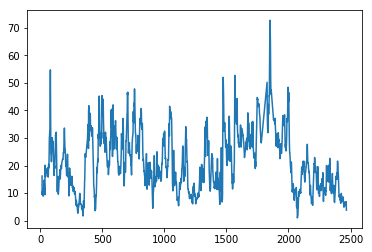

,index,date,ref,PM_6182,PM_6179,PM_617B,PM25_6182,PM25_6179,PM25_617B,rh,t_grad,pressure,temp,pluvio
2458,2458,2017-10-24 00:45:00,6.5,6.1,9.3,9.8,5.8,8.6,8.5,88.3,-0.8,1020.4,15.5,0.0
2459,2459,2017-10-24 01:00:00,6.6,6.6,7.4,10.7,6.3,6.9,9.2,88.7,-0.9,1020.4,15.5,0.0
2460,2460,2017-10-24 01:15:00,5.8,8.5,6.4,13.6,8.0,6.1,11.4,88.7,-0.9,1020.4,15.5,0.0
2461,2461,2017-10-24 01:30:00,5.5,7.9,10.1,14.7,7.5,9.4,12.5,89.0,-0.9,1020.4,15.5,0.0
2462,2462,2017-10-24 01:45:00,6.1,7.2,12.8,11.0,6.9,11.8,9.3,89.0,-0.9,1020.4,15.5,0.0
2463,2463,2017-10-24 02:00:00,5.9,9.3,10.7,11.4,8.7,9.9,9.8,89.2,-0.9,1020.2,15.6,0.0
2464,2464,2017-10-24 02:15:00,6.7,8.4,10.3,12.1,7.8,9.6,10.4,89.3,-0.9,1020.2,15.6,0.0
2465,2465,2017-10-24 02:30:00,6.9,7.1,10.1,9.8,6.7,9.4,8.4,89.1,-0.9,1020.0,15.6,0.0
2466,2466,2017-10-24 02:45:00,5.0,8.2,6.4,8.1,7.9,6.1,6.9,89.0,-0.9,1020.1,15.7,0.0
2467,2467,2017-10-24 03:00:00,3.8,7.5,4.8,7.6,7.2,4.5,6.4,89.0,-0.9,1020.3,15.7,0.0


In [3]:
df = pd.read_pickle(DATA_PATH)
df = df.reset_index()
df = df.dropna()

plt.plot(df["ref"])
plt.show()
df.tail(10)

In [4]:
df.describe()

,index,ref,PM_6182,PM_6179,PM_617B,PM25_6182,PM25_6179,PM25_617B,rh,t_grad,pressure,temp,pluvio
count,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000
mean,1239.796648,21.212086,25.395589,29.926246,36.721835,23.752713,27.815748,31.205514,73.617027,-0.414557,1017.770534,16.697089,0.018747
std,705.400522,10.602717,17.038105,18.893550,23.618640,15.922461,17.544039,20.020547,11.009273,1.829324,5.209971,4.239156,0.124942
min,15.000000,1.000000,1.700000,1.800000,1.300000,1.600000,1.800000,1.100000,42.900000,-3.800000,1003.200000,7.200000,0.000000
25%,639.500000,12.700000,12.600000,15.600000,18.900000,11.800000,14.600000,16.200000,66.800000,-1.700000,1015.800000,14.000000,0.000000
50%,1228.000000,19.500000,20.600000,25.400000,29.700000,19.300000,23.500000,25.200000,76.500000,-0.900000,1018.000000,16.200000,0.000000
75%,1858.500000,28.500000,34.250000,40.900000,52.250000,32.200000,38.100000,44.650000,82.800000,0.200000,1021.100000,19.100000,0.000000
max,2467.000000,72.700000,95.900000,97.700000,118.300000,89.300000,90.400000,98.800000,89.300000,7.600000,1027.100000,30.200000,4.300000


# Pré-traitement

On définit dans un premier des méthodes afin de transformer notre jeu de données en séquences.

In [5]:
def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['PM_6182', 'PM_6179', 'PM_617B', 'PM25_6182', 'PM25_6179', 'PM25_617B', 'temp', 'rh',\
                                 't_grad', 'pressure', 'pluvio']]).reshape(look_back, 1, 11))
        y.append(np.array(df.iloc[i]['ref']))
        i += 1
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

df_test, df_train = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train, 8)
X_valid, y_valid = dataframe_to_xy(df_valid, 8)
X_test, y_test = dataframe_to_xy(df_test, 8)

# Modèles

Nous allons tester 3 modèles récurrents: un modèle récurrent simple (SimpleRNN), un modèle LSTM et un modèle GRU

In [6]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=PATIENCE)

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(SimpleRNN(nb_units, activation='tanh', input_shape=input_dim))
    model.add(Dense(nb_units//2, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(LSTM(nb_units, activation='tanh', input_shape=input_dim))
    model.add(Dense(nb_units//2, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(GRU(nb_units, activation='tanh', input_shape=input_dim))
    model.add(Dense(nb_units//2, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


## Simple RNN

### Apprentissage

In [7]:
model = simple_rnn_model(32, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=16, epochs=1000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,953
Trainable params: 1,953
Non-trainable params: 0
_________________________________________________________________
Train on 1126 samples, validate on 558 samples
Epoch 1/1000
1126/1126 [==============================] - 0s 319us/step - loss: 592.7861 - val_loss: 538.6998
Epoch 2/1000
1126/1126 [==============================] - 0s 160us/step - loss: 571.5681 - val_loss: 516.7891
Epoch 3/1000
1126/1126 [==============================] - 0s 148us/step - loss: 545.3469 - val_loss: 485.9205
Epoch 4/1000
1126/1126 [===

1126/1126 [==============================] - 0s 138us/step - loss: 108.0286 - val_loss: 79.7766
Epoch 69/1000
1126/1126 [==============================] - 0s 151us/step - loss: 107.5832 - val_loss: 80.3010
Epoch 70/1000
1126/1126 [==============================] - 0s 134us/step - loss: 106.9904 - val_loss: 81.8829
Epoch 71/1000
1126/1126 [==============================] - 0s 137us/step - loss: 107.3510 - val_loss: 81.5087
Epoch 72/1000
1126/1126 [==============================] - 0s 135us/step - loss: 106.6933 - val_loss: 80.3191
Epoch 73/1000
1126/1126 [==============================] - 0s 132us/step - loss: 106.8667 - val_loss: 78.3994
Epoch 74/1000
1126/1126 [==============================] - 0s 138us/step - loss: 106.0005 - val_loss: 79.4999
Epoch 75/1000
1126/1126 [==============================] - 0s 138us/step - loss: 106.5296 - val_loss: 78.3958
Epoch 76/1000
1126/1126 [==============================] - 0s 146us/step - loss: 105.9501 - val_loss: 78.2377
Epoch 77/1000
1126/1126 

1126/1126 [==============================] - 0s 134us/step - loss: 102.3995 - val_loss: 74.3586
Epoch 143/1000
1126/1126 [==============================] - 0s 141us/step - loss: 102.5229 - val_loss: 71.2370
Epoch 144/1000
1126/1126 [==============================] - 0s 133us/step - loss: 102.5724 - val_loss: 70.1441
Epoch 145/1000
1126/1126 [==============================] - 0s 137us/step - loss: 102.0601 - val_loss: 73.5611
Epoch 146/1000
1126/1126 [==============================] - 0s 143us/step - loss: 102.3232 - val_loss: 70.6694
Epoch 147/1000
1126/1126 [==============================] - 0s 136us/step - loss: 102.0819 - val_loss: 74.4372
Epoch 148/1000
1126/1126 [==============================] - 0s 143us/step - loss: 102.0519 - val_loss: 70.1042
Epoch 149/1000
1126/1126 [==============================] - 0s 135us/step - loss: 102.1155 - val_loss: 70.2464
Epoch 150/1000
1126/1126 [==============================] - 0s 147us/step - loss: 102.5357 - val_loss: 70.6026
Epoch 151/1000
1

Epoch 216/1000
1126/1126 [==============================] - 0s 140us/step - loss: 101.0377 - val_loss: 68.9540
Epoch 217/1000
1126/1126 [==============================] - 0s 144us/step - loss: 101.2162 - val_loss: 71.8501
Epoch 218/1000
1126/1126 [==============================] - 0s 135us/step - loss: 102.1712 - val_loss: 70.0234
Epoch 219/1000
1126/1126 [==============================] - 0s 130us/step - loss: 101.3518 - val_loss: 69.7875
Epoch 220/1000
1126/1126 [==============================] - 0s 132us/step - loss: 101.6427 - val_loss: 70.4011
Epoch 221/1000
1126/1126 [==============================] - 0s 136us/step - loss: 101.5068 - val_loss: 68.9917
Epoch 222/1000
1126/1126 [==============================] - 0s 145us/step - loss: 101.2592 - val_loss: 69.1809
Epoch 223/1000
1126/1126 [==============================] - 0s 140us/step - loss: 101.3258 - val_loss: 69.9177
Epoch 224/1000
1126/1126 [==============================] - 0s 133us/step - loss: 101.0674 - val_loss: 69.6198
E

### Courbes de résultats pour modèle RNN

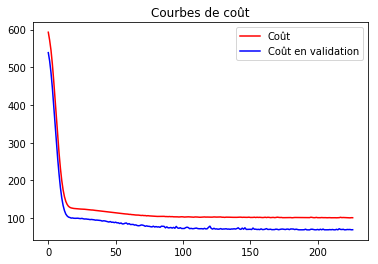

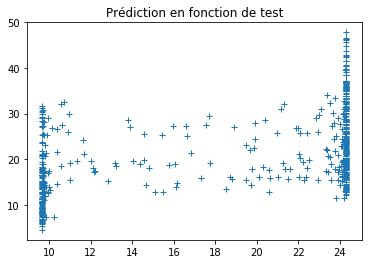

In [8]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## LSTM

### Apprentissage

In [9]:
model = lstm_model(32, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=16, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping,], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5632      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 6,177
Trainable params: 6,177
Non-trainable params: 0
_________________________________________________________________
Train on 1126 samples, validate on 558 samples
Epoch 1/5000
1126/1126 [==============================] - 1s 616us/step - loss: 579.6512 - val_loss: 528.6394
Epoch 2/5000
1126/1126 [==============================] - 0s 368us/step - loss: 562.0415 - val_loss: 507.0798
Epoch 3/5000
1126/1126 [==============================] - 0s 366us/step - loss: 536.0606 - val_loss: 477.7697
Epoch 4/5000
1126/1126 [===

### Courbes de résultats pour modèle LSTM

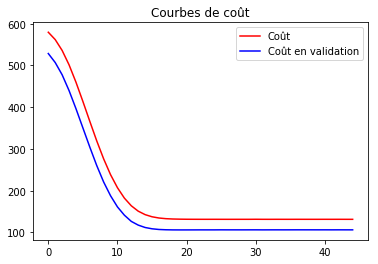

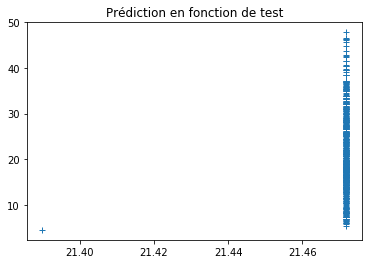

In [10]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## GRU

### Apprentissage

In [11]:
model = gru_model(32, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=16, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4224      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
Train on 1126 samples, validate on 558 samples
Epoch 1/5000
1126/1126 [==============================] - 1s 611us/step - loss: 591.5573 - val_loss: 539.5771
Epoch 2/5000
1126/1126 [==============================] - 0s 333us/step - loss: 573.8809 - val_loss: 519.1012
Epoch 3/5000
1126/1126 [==============================] - 0s 312us/step - loss: 548.8699 - val_loss: 490.3339
Epoch 4/5000
1126/1126 [===

1126/1126 [==============================] - 0s 293us/step - loss: 105.0906 - val_loss: 77.7217
Epoch 69/5000
1126/1126 [==============================] - 0s 306us/step - loss: 104.7775 - val_loss: 77.3390
Epoch 70/5000
1126/1126 [==============================] - 0s 295us/step - loss: 104.7108 - val_loss: 76.7422
Epoch 71/5000
1126/1126 [==============================] - 0s 295us/step - loss: 104.4916 - val_loss: 77.6861
Epoch 72/5000
1126/1126 [==============================] - 0s 303us/step - loss: 104.2208 - val_loss: 76.8234
Epoch 73/5000
1126/1126 [==============================] - 0s 292us/step - loss: 104.4997 - val_loss: 76.9118
Epoch 74/5000
1126/1126 [==============================] - 0s 299us/step - loss: 104.3505 - val_loss: 75.6525
Epoch 75/5000
1126/1126 [==============================] - 0s 302us/step - loss: 104.0861 - val_loss: 76.6499
Epoch 76/5000
1126/1126 [==============================] - 0s 289us/step - loss: 103.7941 - val_loss: 75.5086
Epoch 77/5000
1126/1126 

1126/1126 [==============================] - 0s 321us/step - loss: 100.7846 - val_loss: 70.0357
Epoch 143/5000
1126/1126 [==============================] - 0s 303us/step - loss: 100.5807 - val_loss: 69.4463
Epoch 144/5000
1126/1126 [==============================] - 0s 293us/step - loss: 101.0161 - val_loss: 68.8894
Epoch 145/5000
1126/1126 [==============================] - 0s 336us/step - loss: 100.9772 - val_loss: 68.9207
Epoch 146/5000
1126/1126 [==============================] - 0s 315us/step - loss: 100.4417 - val_loss: 70.1224
Epoch 147/5000
1126/1126 [==============================] - 0s 326us/step - loss: 100.8875 - val_loss: 68.3944
Epoch 148/5000
1126/1126 [==============================] - 0s 320us/step - loss: 100.5151 - val_loss: 68.8333
Epoch 149/5000
1126/1126 [==============================] - 0s 301us/step - loss: 100.5479 - val_loss: 68.8788
Epoch 150/5000
1126/1126 [==============================] - 0s 343us/step - loss: 100.7558 - val_loss: 71.2744
Epoch 151/5000
1

1126/1126 [==============================] - 0s 320us/step - loss: 100.1782 - val_loss: 68.5828
Epoch 217/5000
1126/1126 [==============================] - 0s 320us/step - loss: 99.8967 - val_loss: 68.0573
Epoch 218/5000
1126/1126 [==============================] - 0s 304us/step - loss: 99.8370 - val_loss: 68.8489
Epoch 219/5000
1126/1126 [==============================] - 0s 332us/step - loss: 99.8721 - val_loss: 68.3138
Epoch 220/5000
1126/1126 [==============================] - 0s 316us/step - loss: 99.7640 - val_loss: 68.1332
Epoch 221/5000
1126/1126 [==============================] - 0s 310us/step - loss: 100.2521 - val_loss: 68.0116
Epoch 222/5000
1126/1126 [==============================] - 0s 332us/step - loss: 99.8645 - val_loss: 67.9644
Epoch 223/5000
1126/1126 [==============================] - 0s 324us/step - loss: 100.0567 - val_loss: 68.0040
Epoch 224/5000
1126/1126 [==============================] - 0s 323us/step - loss: 100.6167 - val_loss: 69.0374
Epoch 225/5000
1126/1

### Courbes de résultats pour modèle GRU

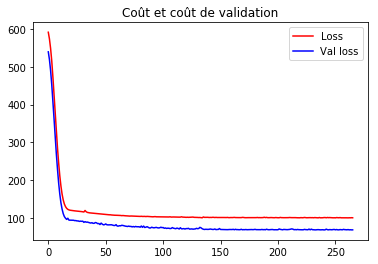

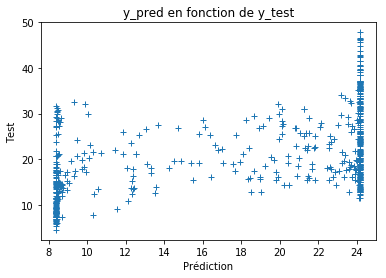

In [12]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

# Conclusion

Nous avons testé des modèles récurrents avec des séquences de points. Avec des séquences plus faibles, le réseau arrive à passer le palier de 106 de val_loss identifié dans le notebook précédent (pour les modèles **SimpleRNN** et **LSTM**. Plusieurs tests ont été effectués pour passer ce palier et la seule combinaison marchant pour passer le palier est celle présentée dans le notebook à savoir une seule couche récurrente et une seule couche Dense. Il a également été testé des apprentissages avec petit batch size et *stochastic gradient descent (SGD)* avec faible pas sans amélioration. La callback keras **ReduceLROnPlateau** a également été testée en combinaison avec la callback **EarlyStopping** elle aussi sans amélioration.

En augmentant le nombres d'unités pour les couches récurrentes et Denses du modèle présenté, le coût stagne au palier de 106 à nouveau. Egalement, en rajoutant une couche Dense après la couche récurrente, le problème subsiste.

Il est intéressant de noter que pour le modèle décrit dans le notebook, si l'on augmente/diminue la séquence donc le **look_back** à 16/8, le palier réapparaît. 